# Import Library
import library

In [217]:
!pip install tensorflow
import seaborn as sns
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import csv
import matplotlib.pyplot as plt

In [83]:
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


# Import Training set and Test set of Titanic Survival

In [84]:
whole_train_set = pd.read_csv('train.csv')
whole_test_set = pd.read_csv('test.csv')

print('shape of train set :',whole_train_set.shape)
print('shape of test set:', whole_test_set.shape)

print('Die rate :', round(np.mean(whole_train_set['Survived'])*100,2), '%')

print(' ---- Null data in train set : ----\n', whole_train_set.isnull().sum())
print(' ---- Null data in test set : ----\n', whole_test_set.isnull().sum())

print(whole_train_set.loc[range(20)])

shape of train set : (891, 12)
shape of test set: (418, 11)
Die rate : 38.38 %
 ---- Null data in train set : ----
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
 ---- Null data in test set : ----
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
    PassengerId  Survived  Pclass  \
0             1         0       3   
1             2         1       1   
2             3         1       3   
3             4         1       1   
4             5         0       3   
5             6         0       3   
6             7         0       1   
7             8         0       3   
8             9         1       3   
9            10

# Cleanse Data

In [85]:
# drop name and ID (These features are unique for every person)
drop_col = ['Name', 'PassengerId']
train_set = whole_train_set.drop(drop_col, axis = 1)
test_set = whole_test_set.drop(drop_col, axis = 1)
print(train_set)

     Survived  Pclass     Sex   Age  SibSp  Parch            Ticket      Fare  \
0           0       3    male  22.0      1      0         A/5 21171    7.2500   
1           1       1  female  38.0      1      0          PC 17599   71.2833   
2           1       3  female  26.0      0      0  STON/O2. 3101282    7.9250   
3           1       1  female  35.0      1      0            113803   53.1000   
4           0       3    male  35.0      0      0            373450    8.0500   
5           0       3    male   NaN      0      0            330877    8.4583   
6           0       1    male  54.0      0      0             17463   51.8625   
7           0       3    male   2.0      3      1            349909   21.0750   
8           1       3  female  27.0      0      2            347742   11.1333   
9           1       2  female  14.0      1      0            237736   30.0708   
10          1       3  female   4.0      1      1           PP 9549   16.7000   
11          1       1  femal

Age features is null about 25%, so this feature should be drop or replace with some values.


In [86]:
%matplotlib inline
# 1 plot age drop null
age_plot = train_set.loc[np.logical_not(train_set['Age'].isnull()), ['Age']]
#sns.distplot(age_plot, bins = 50, axlabel = 'Age drop null', color="r")

# 2 correlation of age vs survival
age_sur = train_set.loc[np.logical_not(train_set['Age'].isnull()) ,'Age'].corr(train_set.loc[np.logical_not(train_set['Age'].isnull()) ,'Survived'])
print(age_sur)

# 3 drop age
train_set = train_set.drop(['Age'], axis = 1)
test_set = test_set.drop(['Age'], axis = 1)

-0.0772210945722


In [87]:
# Find distinct values for categorical features
choose_elements = ['Embarked', 'Ticket', 'Cabin', 'Parch']
train_set_copy = train_set.copy()
train_set_copy = train_set_copy[choose_elements]
# print(train_set_copy)

for col in choose_elements:
    print('Unique Value for', col,':', train_set_copy[col].unique().shape[0])
    print('Unique of', col,':', train_set_copy[col].unique() )
    

Unique Value for Embarked : 4
Unique of Embarked : ['S' 'C' 'Q' nan]
Unique Value for Ticket : 681
Unique of Ticket : ['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151' '347082'
 '350406' '248706' '382652' '244373' '345763' '2649' '239865' '248698'
 '330923' '113788' '347077' '2631' '19950' '330959' '349216' 'PC 17601'
 'PC 17569' '335677' 'C.A. 24579' 'PC 17604' '113789' '2677' 'A./5. 2152'
 '345764' '2651' '7546' '11668' '349253' 'SC/Paris 2123' '330958'
 'S.C./A.4. 23567' '370371' '14311' '2662' '349237' '3101295' 'A/4. 39886'
 'PC 17572' '2926' '113509' '19947' 'C.A. 31026' '2697' 'C.A. 34651'
 'CA 2144' '2669' '113572' '36973' '347088' 'PC 17605' '2661' 'C.A. 29395'
 'S.P. 3464' '3101281' '315151' 'C.A. 33111' 'S.O.C. 14879' '2680' '1601'
 '348123' '349208' '374746' '248738' '364516' '345767' '345779' '330932'
 '113059' 'SO/C 14885' '3101278' 'W./C. 6608' 'SOTON/OQ 392086' '343275'
 '343276' '347

In [88]:
## Deal with Cabin features -> change string feature to numeric feature
# step 1 change null in column to N (no cabin)
train_set.loc[train_set['Cabin'].isnull(), 'Cabin'] = 'N'

# step 2 change cabin type to abbreviate type (neglect number of cabin)
train_set.loc[:, 'Cabin'] = train_set.loc[:, 'Cabin'].map(lambda x: str(x)[0])

# step 3 identify unique value for cabin features
print('Unique Value for featured Cabin :',train_set['Cabin'].unique())

# step 4 replace categorical with features
dic_cabin = {'N':0, 'C':1, 'E':2, 'G':3, 'D':4, 'A':5, 'B':6, 'F':7, 'T':8}
train_set['Cabin_Numeric'] = train_set['Cabin'].map(dic_cabin)

# step 5 drop cabin
train_set = train_set.drop(['Cabin'], axis = 1)

print(train_set)

Unique Value for featured Cabin : ['N' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
     Survived  Pclass     Sex  SibSp  Parch            Ticket      Fare  \
0           0       3    male      1      0         A/5 21171    7.2500   
1           1       1  female      1      0          PC 17599   71.2833   
2           1       3  female      0      0  STON/O2. 3101282    7.9250   
3           1       1  female      1      0            113803   53.1000   
4           0       3    male      0      0            373450    8.0500   
5           0       3    male      0      0            330877    8.4583   
6           0       1    male      0      0             17463   51.8625   
7           0       3    male      3      1            349909   21.0750   
8           1       3  female      0      2            347742   11.1333   
9           1       2  female      1      0            237736   30.0708   
10          1       3  female      1      1           PP 9549   16.7000   
11          1       1  femal

In [89]:
## Deal with embarked features -> change embark feature to numerical
# step 1 convert null value to unknown
train_set.loc[train_set['Embarked'].isnull(),'Embarked'] = 'unknown'
test_set.loc[test_set['Embarked'].isnull(),'Embarked'] = 'unknown'

# step 2 convert string to numeric value
dic_embarked = {'S':0, 'C':1, 'Q':2, 'unknown':3}
train_set['Embarked_Numeric'] = train_set['Embarked'].map(dic_embarked)
test_set['Embarked_Numeric'] = test_set['Embarked'].map(dic_embarked)

# step 3 drop embarked feature
train_set = train_set.drop(['Embarked'], axis = 1)
test_set = test_set.drop(['Embarked'], axis = 1)

print(train_set)


     Survived  Pclass     Sex  SibSp  Parch            Ticket      Fare  \
0           0       3    male      1      0         A/5 21171    7.2500   
1           1       1  female      1      0          PC 17599   71.2833   
2           1       3  female      0      0  STON/O2. 3101282    7.9250   
3           1       1  female      1      0            113803   53.1000   
4           0       3    male      0      0            373450    8.0500   
5           0       3    male      0      0            330877    8.4583   
6           0       1    male      0      0             17463   51.8625   
7           0       3    male      3      1            349909   21.0750   
8           1       3  female      0      2            347742   11.1333   
9           1       2  female      1      0            237736   30.0708   
10          1       3  female      1      1           PP 9549   16.7000   
11          1       1  female      0      0            113783   26.5500   
12          0       3    

In [90]:
## Deal with sex features
# convert string to numeric value
dic_sex = {'male':0, 'female':1}
train_set['Sex_Numeric'] = train_set['Sex'].map(dic_sex)
test_set['Sex_Numeric'] = train_set['Sex'].map(dic_sex)

# drop sex features
train_set = train_set.drop(['Sex'], axis = 1)
test_set = test_set.drop(['Sex'], axis = 1)
print(train_set)

     Survived  Pclass  SibSp  Parch            Ticket      Fare  \
0           0       3      1      0         A/5 21171    7.2500   
1           1       1      1      0          PC 17599   71.2833   
2           1       3      0      0  STON/O2. 3101282    7.9250   
3           1       1      1      0            113803   53.1000   
4           0       3      0      0            373450    8.0500   
5           0       3      0      0            330877    8.4583   
6           0       1      0      0             17463   51.8625   
7           0       3      3      1            349909   21.0750   
8           1       3      0      2            347742   11.1333   
9           1       2      1      0            237736   30.0708   
10          1       3      1      1           PP 9549   16.7000   
11          1       1      0      0            113783   26.5500   
12          0       3      0      0         A/5. 2151    8.0500   
13          0       3      1      5            347082   31.275

In [91]:
## Deal with Ticket features
# drop Ticket feature
train_set = train_set.drop(['Ticket'], axis = 1)
test_set = test_set.drop(['Ticket'], axis = 1)

print(train_set)

     Survived  Pclass  SibSp  Parch      Fare  Cabin_Numeric  \
0           0       3      1      0    7.2500              0   
1           1       1      1      0   71.2833              1   
2           1       3      0      0    7.9250              0   
3           1       1      1      0   53.1000              1   
4           0       3      0      0    8.0500              0   
5           0       3      0      0    8.4583              0   
6           0       1      0      0   51.8625              2   
7           0       3      3      1   21.0750              0   
8           1       3      0      2   11.1333              0   
9           1       2      1      0   30.0708              0   
10          1       3      1      1   16.7000              3   
11          1       1      0      0   26.5500              1   
12          0       3      0      0    8.0500              0   
13          0       3      1      5   31.2750              0   
14          0       3      0      0    7

# Visualize features

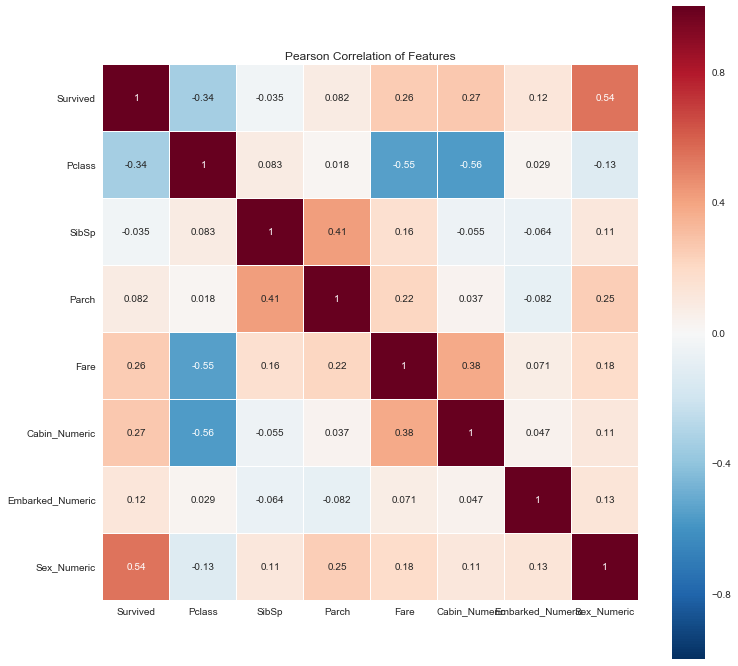

In [175]:
# Visualize correlation of each features
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features')
sns.heatmap(train_set.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)

Survived Min val : 0 Max val : 1 Mean val : 0.38 Median val : 0.0 Std val : 0.49
Pclass Min val : 1 Max val : 3 Mean val : 2.31 Median val : 3.0 Std val : 0.84
SibSp Min val : 0 Max val : 8 Mean val : 0.52 Median val : 0.0 Std val : 1.1
Parch Min val : 0 Max val : 6 Mean val : 0.38 Median val : 0.0 Std val : 0.81
Fare Min val : 0.0 Max val : 512.33 Mean val : 32.2 Median val : 14.45 Std val : 49.67
Cabin_Numeric Min val : 0 Max val : 8 Mean val : 0.81 Median val : 0.0 Std val : 1.81
Embarked_Numeric Min val : 0 Max val : 3 Mean val : 0.37 Median val : 0.0 Std val : 0.65
Sex_Numeric Min val : 0 Max val : 1 Mean val : 0.35 Median val : 0.0 Std val : 0.48


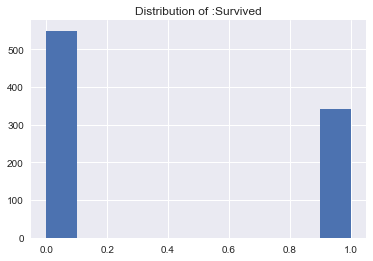

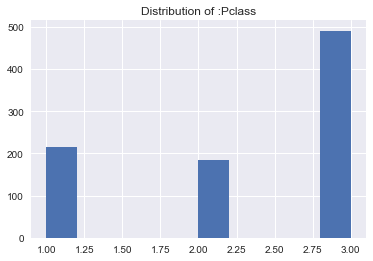

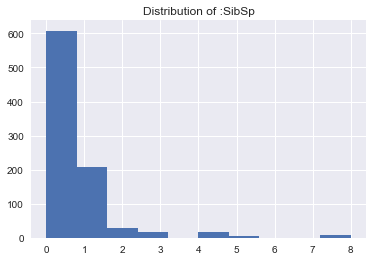

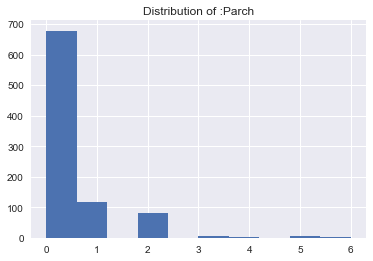

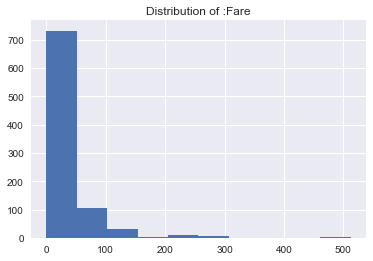

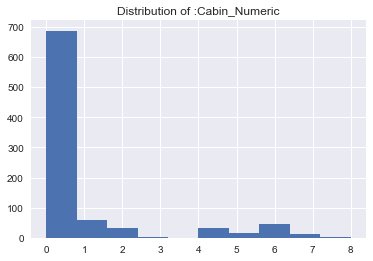

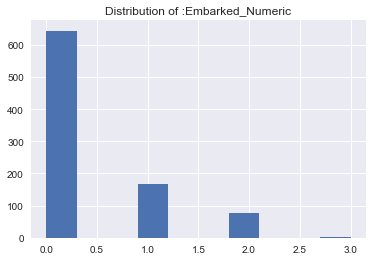

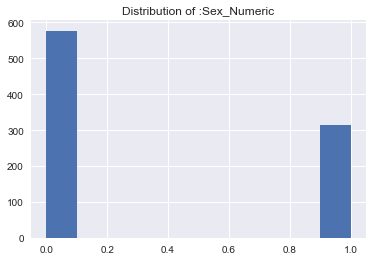

In [93]:
## visualize distribution of each features

col_interest = ['Fare', 'SibSp', 'Parch']

def r2(x): return round(x,2)

for col in list(train_set):
    fig = plt.figure()
    ax1 = fig.gca()
    
    plt.hist(train_set[col])
    print(col, 'Min val :',np.min(train_set[col]),'Max val :', r2(np.max(train_set[col])), 
          'Mean val :', r2(np.mean(train_set[col])), 'Median val :', r2(np.median(train_set[col]))
          , 'Std val :', r2(np.std(train_set[col])))
    plt.title('Distribution of :' + col)

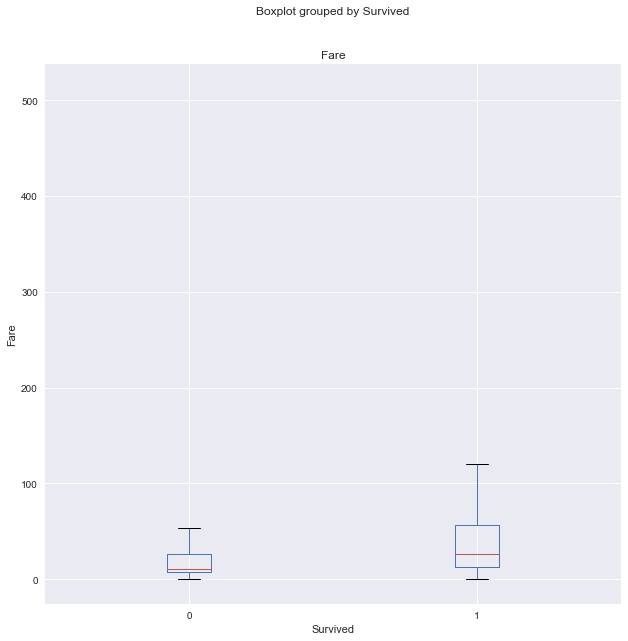

In [94]:
## visualize box plot

col_interest = ['Fare']
for col in col_interest:
    fig = plt.figure()
    train_set.boxplot(column = col, by = ['Survived'], figsize = (10,10))
    plt.xlabel('Survived')
    plt.ylabel(col)

dead
 0    468
1     81
Name: Sex_Numeric, dtype: int64
survived
 0    109
1    233
Name: Sex_Numeric, dtype: int64
0    549
Name: Survived, dtype: int64


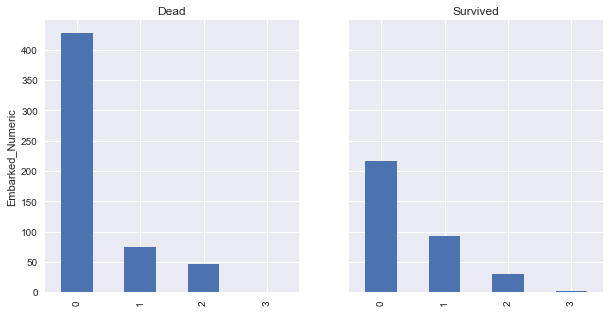

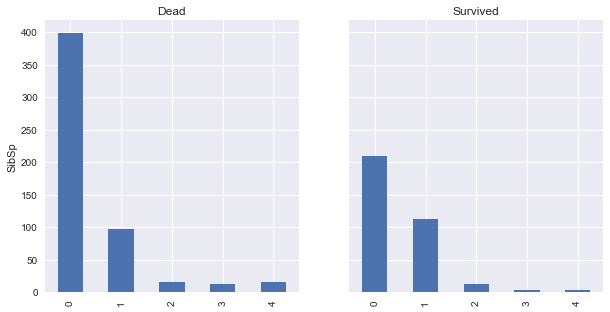

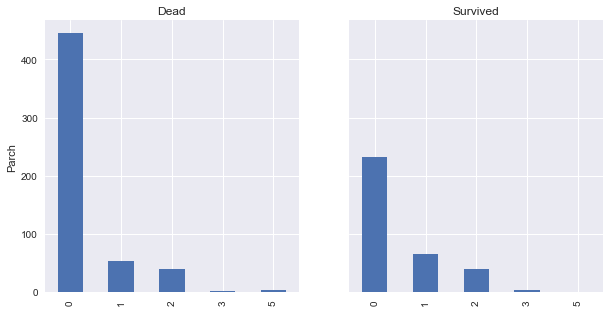

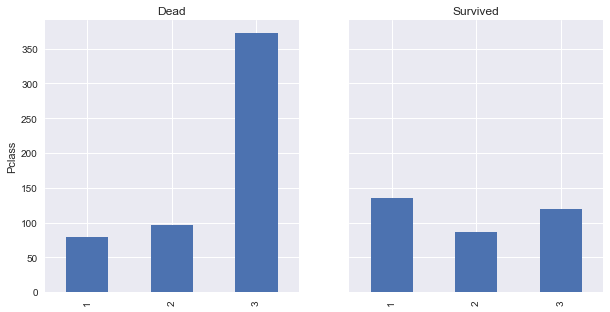

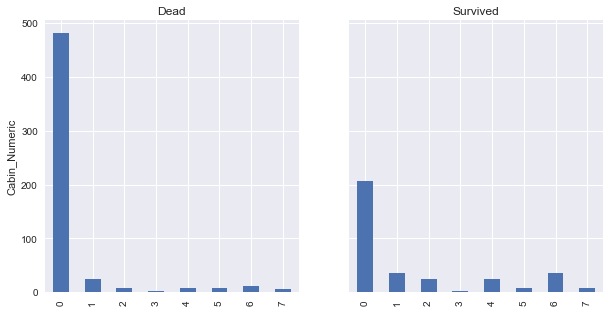

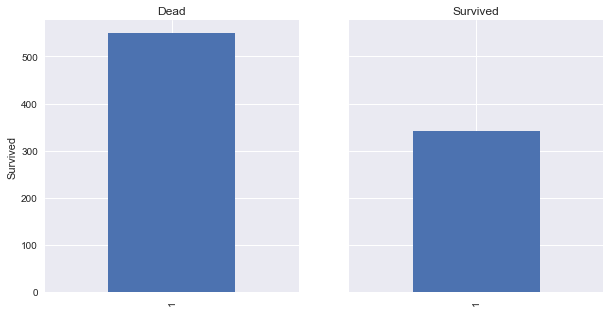

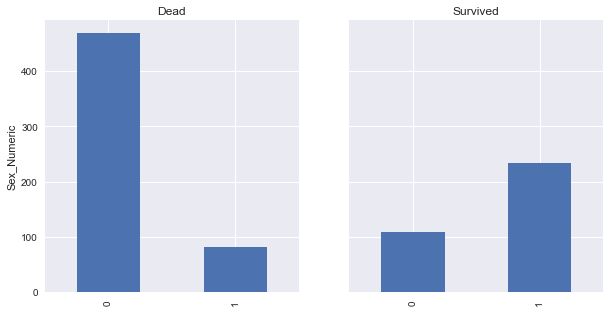

In [95]:
## Visualize barplot group by survived

print('dead\n', train_set.loc[train_set['Survived'] == 0, 'Sex_Numeric'].value_counts(sort = False))
print('survived\n', train_set.loc[train_set['Survived'] == 1, 'Sex_Numeric'].value_counts(sort = False))

for col in set(list(train_set)) - set(['Fare']):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex = True, sharey = True)
    train_set.loc[train_set['Survived'] == 0, col].value_counts(sort = False).plot(kind = 'bar', ax = ax1)
    ax1.set_title('Dead')
    train_set.loc[train_set['Survived'] == 1, col].value_counts(sort = False).plot(kind = 'bar', ax = ax2)
    ax2.set_title('Survived')
    ax1.set_ylabel(col)
    
print(train_set.loc[train_set['Survived'] == 0, 'Survived'].value_counts())


# Deep Learning NN
N-layer NN are used to learn survival of passenger.

In [111]:
## create x_train, x_test and y_train
train_set_feature = train_set.drop(['Survived'], axis = 1) # drop label output

x_train = train_set_feature.as_matrix().T
x_test = test_set.as_matrix().T

y_train = train_set['Survived'].as_matrix().T
y_train = y_train.reshape(1, len(y_train))

print('Shape of X for train', x_train.shape)
print('Shape of Y for train', y_train.shape)
print('Shape of X for test', x_test.shape)

Shape of X for train (7, 891)
Shape of Y for train (1, 891)
Shape of X for test (7, 418)


# Create Place Holders (Input, Output)
Create method for crate place holder

In [228]:
# place holders

def create_placeholders(n_x, n_y):
    '''
    Creates place holders for TensorFlow session (Place holders is a variable that can be update during sessions)
    
    Arguments:
    n_x = Number of input features
    n_y = Number of label outputs
    
    Return:
    X = placeholders for input
    Y = labels for output
    '''
    
    X = tf.placeholder(tf.float32, shape = (n_x, None), name = 'X')
    Y = tf.placeholder(tf.float32, shape = (n_y, None), name = 'Y')
    
    return X, Y

In [230]:
# Unit test
X, Y = create_placeholders(7, 1)
print('X =', X)
print('Y =', Y)

X = Tensor("X_6:0", shape=(7, ?), dtype=float32)
Y = Tensor("Y_6:0", shape=(1, ?), dtype=float32)


# Create Initializing parameters method

In [254]:
# create initializing parameters 

def initialize_parameters_deep(layers_dim):
    '''
    Create and initialize parameters according to number of hidden neuron in each layers.
    
    Arguments:
    layer_dim = vector of number of hidden neuron in each layer, eg. [n_x, 5, 3, n_y] 
    
    Return:
    parameters = dictionary of tensor variables w and b
    '''
    
    graph = tf.Graph()
    with graph.as_default(): # reset to default graph every times
        
        tf.set_random_seed(1)
        num_layers = len(layers_dim)

        for i in range(num_layers-1):
            parameters['W'+str(i+1)] = tf.get_variable('W' + str(i+1), [layers_dim[i+1], layers_dim[i]], initializer = tf.contrib.layers.xavier_initializer(seed = 123))
            parameters['b'+str(i+1)] = tf.get_variable('b' + str(i+1), [layers_dim[i+1], 1], initializer = tf.zeros_initializer())    
    return parameters


In [256]:
parameters = initialize_parameters_deep([5, 4, 3])
print('W1', parameters['W1'])
print('b1', parameters['b1'])
print('W2', parameters['W2'])
print('b2', parameters['b2'])

W1 <tf.Variable 'W1:0' shape=(4, 5) dtype=float32_ref>
b1 <tf.Variable 'b1:0' shape=(4, 1) dtype=float32_ref>
W2 <tf.Variable 'W2:0' shape=(3, 4) dtype=float32_ref>
b2 <tf.Variable 'b2:0' shape=(3, 1) dtype=float32_ref>
